In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from math import sqrt

## Import Data

In [2]:
df = pd.read_csv('../../data/merged_all_values.csv')

## Take Subset Of Data To Only Include Years 2017, 2018, 2019 and 2020

In [3]:
df = df[(df.YEAR == 2017) | (df.YEAR == 2018) | (df.YEAR == 2019) | (df.YEAR == 2020)]

## Create Train And Test Datasets

In [4]:
train = df[df.YEAR != 2020]
test = df[df.YEAR == 2020]

## Keep Only The TOTALDEMAND COlumn

In [5]:
train = pd.DataFrame(train['TOTALDEMAND'])
test = pd.DataFrame(test['TOTALDEMAND'])

## Create Matrix With Lookback Values

In [6]:
def create_dataset(df, previous=1):
    dataX, dataY = [], []
    for i in range(len(df)-previous-1):
        a = df[i:(i+previous), 0]
        dataX.append(a)
        dataY.append(df[i + previous, 0])
    return np.array(dataX), np.array(dataY)

## Normalize Train And Test Datasets

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.fit_transform(test)

## Configure Lookback Period And Apply To Train And Test Datasets

In [8]:
lookback = 72
X_train, y_train = create_dataset(train, lookback)
X_test, y_test = create_dataset(test, lookback)

In [9]:
# NB: The length of each record in X_train/X_test becomes the number of previous Total Demand values (scaled) which is
#     determined by the value set for lookback.
#     Also the higher the lookback value then the smaller X-train becomes. For example if the lookback value is 72 then the
#     first X value cannot be created until the 73rd timestamp as it is the first time it has 72 previous values to
#     lookback at.
X_train.shape

(52487, 72)

## Reshape Train And Test Datasets To Represent Samples, Time Steps And Features

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

## Configure LSTM Neural Network

In [11]:
model = Sequential()
model.add(LSTM(25, input_shape=(1, lookback)))
model.add(Dense(1))
opt = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)

## Fit Model To Train Dataset

In [12]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=15, batch_size=20, verbose=2)

Epoch 1/15
2100/2100 - 3s - loss: 0.0010 - val_loss: 2.8566e-04
Epoch 2/15
2100/2100 - 2s - loss: 2.2227e-04 - val_loss: 1.7109e-04
Epoch 3/15
2100/2100 - 3s - loss: 1.7004e-04 - val_loss: 1.2844e-04
Epoch 4/15
2100/2100 - 3s - loss: 1.4968e-04 - val_loss: 1.1517e-04
Epoch 5/15
2100/2100 - 3s - loss: 1.3550e-04 - val_loss: 1.9718e-04
Epoch 6/15
2100/2100 - 3s - loss: 1.2789e-04 - val_loss: 1.0678e-04
Epoch 7/15
2100/2100 - 3s - loss: 1.1546e-04 - val_loss: 9.7043e-05
Epoch 8/15
2100/2100 - 3s - loss: 1.0887e-04 - val_loss: 9.0866e-05
Epoch 9/15
2100/2100 - 3s - loss: 1.0825e-04 - val_loss: 9.2499e-05
Epoch 10/15
2100/2100 - 3s - loss: 1.0499e-04 - val_loss: 8.4408e-05
Epoch 11/15
2100/2100 - 2s - loss: 1.0015e-04 - val_loss: 9.2607e-05
Epoch 12/15
2100/2100 - 2s - loss: 9.6421e-05 - val_loss: 7.7051e-05
Epoch 13/15
2100/2100 - 3s - loss: 9.4450e-05 - val_loss: 9.8761e-05
Epoch 14/15
2100/2100 - 2s - loss: 9.0703e-05 - val_loss: 8.1789e-05
Epoch 15/15
2100/2100 - 2s - loss: 9.2558e-05 -

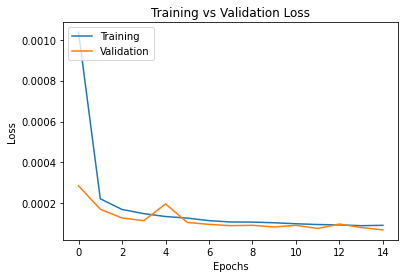

In [13]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Make Predictions Using Test Dataset

In [14]:
y_pred = model.predict(X_test)

## Convert Values Back To Regular Values

In [15]:
# Typically you would not scale y values. However, as the scaled total demand values were used to create both the x and y
# values, the scaling for the prediction and y test now needs to be reversed.
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform([y_test])

## Calculate RMSE

In [16]:
y_test = y_test.reshape(-1)
y_test = pd.Series(y_test)

y_pred = y_pred.reshape(-1)
y_pred = pd.Series(y_pred)

In [17]:
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 81.161895


## Average Percentage Difference Between Prediction And Actual Values

In [18]:
predict_actual = y_test.to_frame()
predict_actual['PREDICTION'] = y_pred
predict_actual.columns = ['ACTUAL', 'PREDICTION']
predict_actual['PERCENT_DIFF'] = abs(predict_actual.ACTUAL - predict_actual.PREDICTION) / predict_actual.ACTUAL * 100

In [19]:
avg_perc_diff = sum(predict_actual.PERCENT_DIFF) / len(predict_actual)
avg_perc_diff

0.7759137465666793